<a href="https://colab.research.google.com/github/kahliburke/LinkedInDataScience/blob/main/CO2_Growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Get Data
Let's download the data set for the Mauna Loa CO2 measurements, monthly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.odr as odr
from scipy.odr import Model, Data, ODR
import scipy

df = pd.read_csv("https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", comment = "#")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            785 non-null    int64  
 1   month           785 non-null    int64  
 2   decimal date    785 non-null    float64
 3   average         785 non-null    float64
 4   deseasonalized  785 non-null    float64
 5   ndays           785 non-null    int64  
 6   sdev            785 non-null    float64
 7   unc             785 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 49.2 KB


#Plot the data
Here we see the two data fields, one giving the montly average, and the other giving the deseasonalized monthly average, since CO2 spikes in the winter as plants absorb less CO2 than in the summer.

<Axes: xlabel='decimal date'>

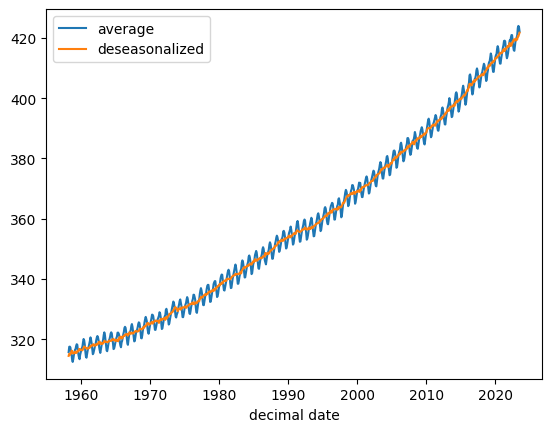

In [ ]:
df.plot(x="decimal date", y=["average", "deseasonalized"])

To my eyes, right away this does not have the appearance of a linear process. There seems to be curvature. However, let's try a linear fit and see how well it does.

In [ ]:
x = df["decimal date"]
y = df["deseasonalized"]

data = Data(x, y)

lin_odr = ODR(data, odr.unilinear)
lin_out = lin_odr.run()
lin_out.pprint()

Beta: [ 1.64691739e+00 -2.92050715e+03]
Beta Std Error: [8.14693931e-03 1.62202550e+01]
Beta Covariance: [[ 1.33956749e-05 -2.66691059e-02]
 [-2.66691059e-02  5.30995686e+01]]
Residual Variance: 4.954779849992238
Inverse Condition #: 4.737662921531473e-06
Reason(s) for Halting:
  Sum of squares convergence


The fitting process converged to the best possible, we can plot that against the deseasonalized data now.

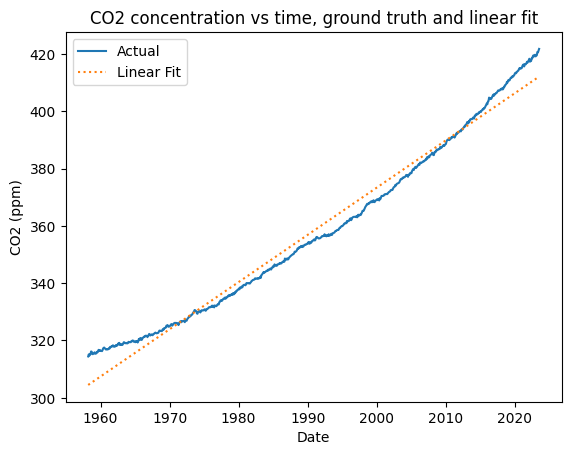

In [ ]:
(m, b) = lin_out.beta
lin_fit_y = [m*x+b for x in x]

ax = df.plot(x="decimal date", y=["deseasonalized"])
ax.plot(x, lin_fit_y, ':')

ax.legend(["Actual", "Linear Fit"])
plt.xlabel("Date")
plt.ylabel("CO2 (ppm)")
plt.title('CO2 concentration vs time, ground truth and linear fit')
plt.show()

Well ... it's a line, it sort of fits the data, but it really seems like there is curvature. Let's look at the residuals.

#Structure in residuals


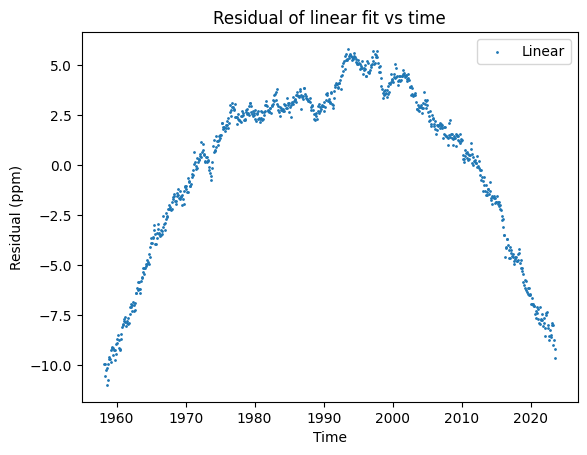

In [ ]:
df["res_lin_y"] = lin_fit_y - df["deseasonalized"]
ax = df.plot.scatter(x="decimal date", y="res_lin_y", s = 1)
ax.set_ylabel("Residual (ppm)")
ax.set_xlabel("Time")
ax.legend(["Linear"])
plt.title("Residual of linear fit vs time")
plt.show()


This plot shows that the residuals are not just noise, there is a definite structure. The linear fit underestimates at each end, and overestimates in the middle.

If I wanted to test that a dataset was linear, I could use the tools of calculus (pretending for a moment that the curve is continuous). If I wanted to know whether a curve was linear, I should look at the slope. A line has a fixed slope, so if that's the case, a plot of the derivative would be a constant value. I will take the first difference of this discrete data set whhich is the discrete equivalent of taking the first derivative of a continuous function. Then I will plot the derivative. I will apply a moving average for a little data smoothing, but this isn't necessary for the results. It just tames the noise a little bit and makes the trend easier to see visually.

<Axes: xlabel='decimal date'>

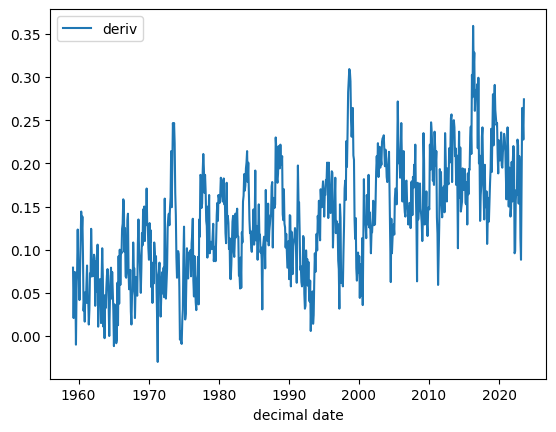

In [ ]:
# Apply moving window average with a window of 1 year (12 months)
df["deriv"] = df["deseasonalized"].diff(1).rolling(12).mean()
df = df.dropna()
df.plot("decimal date", "deriv")

Ok, that to me is definitely not flat. Let's try to fit a line to this data.

In [ ]:
x = df["decimal date"]
y = df["deriv"]

data = Data(x, y)

dlin_odr = ODR(data, odr.unilinear)
dlin_out = dlin_odr.run()
dlin_out.pprint()

Beta: [ 2.28839083e-03 -4.42176048e+00]
Beta Std Error: [9.66986315e-05 1.92571575e-01]
Beta Covariance: [[ 3.74086315e-06 -7.44945911e-03]
 [-7.44945911e-03  1.48359558e+01]]
Residual Variance: 0.002499590325637378
Inverse Condition #: 4.686685274468615e-06
Reason(s) for Halting:
  Sum of squares convergence


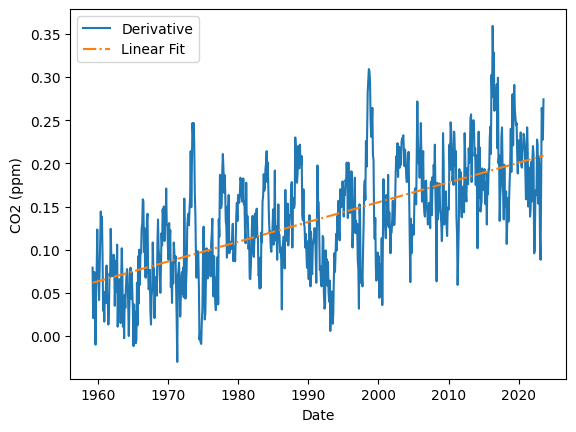

In [ ]:
x = df["decimal date"]
(m, b) = dlin_out.beta
dlin_fit_y = [m*x+b for x in x]
ax = df.plot(x="decimal date", y=["deriv"])
ax.plot(x, dlin_fit_y, '-.')
ax.legend(["Derivative", "Linear Fit"])

plt.xlabel("Date")
plt.ylabel("CO2 (ppm)")
#plt.title('')
plt.show()

So there is a clear linear trend in the data indicating that (at least in this time period) the strongest polynomial contribution is quadratic.
#Quadratic fit

In [ ]:
x = df["decimal date"]
y = df["deseasonalized"]
data = Data(x, y)
quad_odr = ODR(data, odr.quadratic)
quad_out = quad_odr.run()
quad_out.pprint()

Beta: [ 1.29561198e-02 -4.99624723e+01  4.84700483e+04]
Beta Std Error: [9.09407520e-05 3.61623812e-01 3.59472761e+02]
Beta Covariance: [[ 4.82013637e-08 -1.91669931e-04  1.90524821e-01]
 [-1.91669931e-04  7.62177782e-01 -7.57637505e+02]
 [ 1.90524821e-01 -7.57637505e+02  7.53137406e+05]]
Residual Variance: 0.1715764810587012
Inverse Condition #: 1.904324490126786e-11
Reason(s) for Halting:
  Sum of squares convergence


The quadratic fit converged properly, so lets now plot the two fitted models against the data.

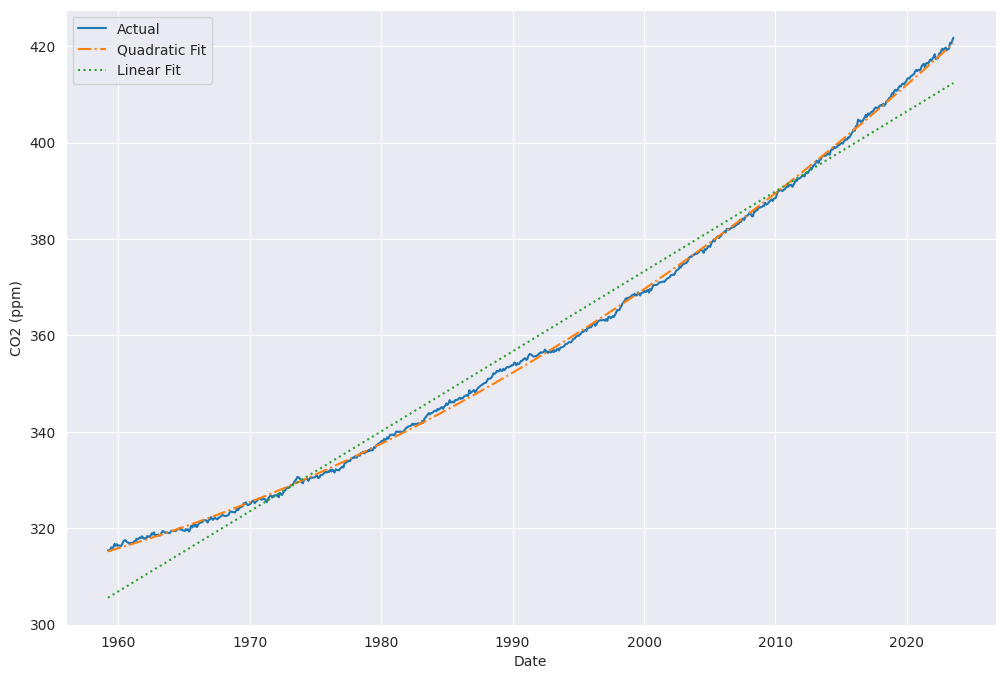

In [ ]:
# Since the data length changed due to windowing, calculate again
x = df["decimal date"]
y = df["deseasonalized"]

data = Data(x, y)

lin_odr = ODR(data, odr.unilinear)
lin_out = lin_odr.run()
(m, b) = lin_out.beta
lin_fit_y = [m*x+b for x in x]

(a,b,c) = quad_out.beta
quad_fit_y = [a*x**2+b*x+c for x in x]

%matplotlib inline
ax = df.plot(x="decimal date", y=["deseasonalized"], figsize=(12, 8))
ax.plot(x, quad_fit_y, '-.')
ax.plot(x, lin_fit_y, ':')

ax.legend(["Actual", "Quadratic Fit", "Linear Fit"])
plt.xlabel("Date")
plt.ylabel("CO2 (ppm)")

#plt.title('')
fig.show()


That looks like a much better fit. Let's compare residuals.

#Residual Analysis

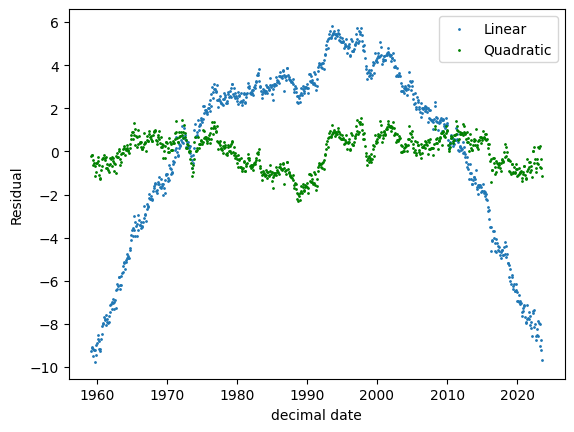

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
df["res_quad_y"] = quad_fit_y - df["deseasonalized"]
ax = df.plot.scatter(x="decimal date", y="res_lin_y", s = 1)
df.plot.scatter(x="decimal date", y="res_quad_y", s = 1, ax=ax, c="g")
ax.set_ylabel("Residual")
ax.legend(["Linear", "Quadratic"])
plt.show()

Not only are the residuals much smaller, but they look more normally distributed. In fact, let's compare the distribution of the residuals, which should approximate a gaussian if they are truly noise. First a visual inspection via histogram is a decent idea.

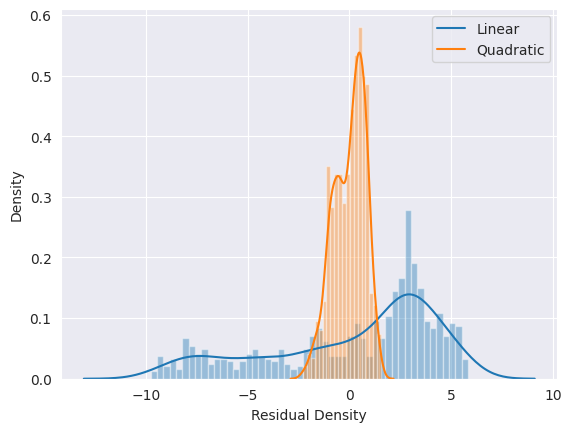

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
ax = sns.distplot(df["res_lin_y"], bins=50)
sns.distplot(df["res_quad_y"], bins=20)
ax.legend(["Linear", "Quadratic"])
ax.set_xlabel("Residual Density")
plt.show()

What we see here is that neither distribution is a perfect Gaussian, but the quadratic is much much closer, the linear one is very far from normal and may display some bi-modal behavior because of the underfitting at either end of the data.

Another test is a probability *Q-Q* plot. First let's create a gaussian dataset and test it.

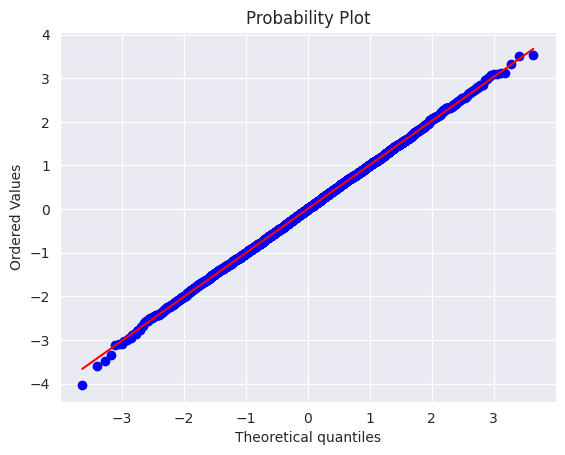

In [ ]:
norm_data = np.random.randn(5000)
stats.probplot(norm_data, dist="norm", plot=plt)
plt.show()

When the data is gaussian, the probplot should adhere to the diagonal line.

Now for our two resisdual fits,

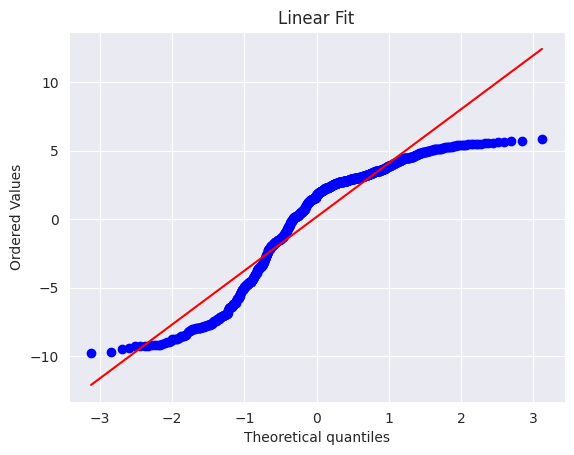

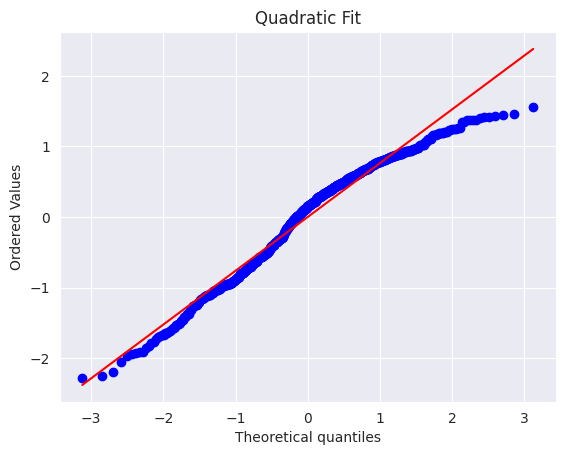

In [ ]:
import pylab
import scipy.stats as stats

stats.probplot(df['res_lin_y'], dist="norm", plot=plt)
plt.title("Linear Fit")
plt.show()
stats.probplot(df['res_quad_y'], dist="norm", plot=plt)
plt.title("Quadratic Fit")
plt.show()


Again, neither is perfect but the quadratic is much closer to normal.

THere are also some statistical tests we can apply, let's look at the *Kolmogorov–Smirnov* test and the *Shapiro* test. These both are tests to determine whether the null hypothesis that the data is sampled from a normal distribution can be rejected. If the p value is < 0.05, the null hypothesis can be rejected at the 95% confidence level, meaning there would be only a 5% chance of seeing that pattern of data if sampling from a normal distribution. Of course we can choose whatever confidence level we want, 95% is common in social sciences especially but we probably would want something more like 99% or even 99.9% to be really convicing.

In [ ]:
from scipy import stats
import numpy as np
cols = ["res_lin_y", "res_quad_y"]
stat_df = pd.DataFrame({"Fit": ["Linear", "Quadratic"], "K-S Test": [stats.kstest(df[f], "norm") for f in cols],
                        "Shapiro Test": [stats.shapiro(df[f]) for f in cols]})
stat_df

,Fit,K-S Test,Shapiro Test
0,Linear,"(0.4648060733073498, 1.7144808015714213e-153)","(0.897194504737854, 2.520446438020666e-22)"
1,Quadratic,"(0.10138718388619383, 2.2696864114616193e-07)","(0.9708079695701599, 2.637514338876823e-11)"


So as expected, the null hypothesis can be rejected, and we interpret that as indicating neither distribution is truly gaussian. However, look at the p value for the linear fit, especially the K-S test at 10^-153! That's a lot of confidence it's not normal.